In [1]:
import pandas as pd

In [70]:
dataset_rw = pd.read_parquet("data/raw_dataset.parquet")
hierarchy_df = pd.read_parquet("data/hierarchy_category.parquet")

In [3]:
dataset_rw.columns

Index(['timestamp_x', 'visitorid', 'event', 'itemid', 'timestamp_y',
       'property', 'available', 'categoryid', 'value_count', 'value_first',
       'value_last', 'value_min', 'value_max', 'value_mean', 'value_std',
       'level_0', 'level_1', 'level_2', 'level_3', 'level_4', 'level_5',
       'root_category'],
      dtype='object')

In [4]:
from datetime import datetime


split_date = datetime.fromisoformat("2015-08-29")
split_date_ms = int(split_date.timestamp() * 1000)


print(dataset_rw.query(f"timestamp_x <{split_date_ms}").shape)

print(dataset_rw.query(f"timestamp_x > {split_date_ms}").shape)

(42986288, 22)
(10390959, 22)


In [5]:
from datetime import datetime


def split_data(
    data: pd.DataFrame, timestamp_column: str, split_date: str
) -> tuple[pd.DataFrame, pd.DataFrame]:
    split_date = datetime.fromisoformat(split_date)
    split_date_ms = int(split_date.timestamp() * 1000)
    train = data.query(f"{timestamp_column}<{split_date_ms}")
    test = data.query(f"{timestamp_column}>={split_date_ms}")
    return train, test

In [6]:
train, test = split_data(dataset_rw, "timestamp_x", "2015-08-29")


print(train.shape[0] + test.shape[0], dataset_rw.shape[0])

53377247 53377247


In [7]:
train["visitorid"].nunique()

991969

In [8]:
train["root_category"].nunique()

24

In [9]:
del dataset_rw

In [11]:
import numpy as np

nums = [
    "property",
    "value_count",
    "value_first",
    "value_last",
    "value_min",
    "value_max",
    "value_mean",
    "value_std",
]

cats = [
    item
    for item in train.columns
    if item not in (nums + ["timestamp_x", "timestamp_y"])
]


mask_inf = np.isinf(train[nums]).any()


train[nums] = train[nums].replace([np.inf, -np.inf], np.nan)

mask_inf = np.isinf(test[nums]).any()


test[nums] = test[nums].replace([np.inf, -np.inf], np.nan)

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, RobustScaler

transformer_params = {
    "transformers": [
        ("cats", OrdinalEncoder(), cats),
        ("numscaler", RobustScaler(), nums),
    ],
    "remainder": "passthrough",
    "verbose": True,
}

In [13]:
train_transformer = ColumnTransformer(**transformer_params).fit(X=train)

[ColumnTransformer] .......... (1 of 3) Processing cats, total=  18.7s
[ColumnTransformer] ..... (2 of 3) Processing numscaler, total=   7.9s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


In [ ]:
test_transformer = ColumnTransformer(**transformer_params).fit(X=test)

[ColumnTransformer] .......... (1 of 3) Processing cats, total=   3.5s
[ColumnTransformer] ..... (2 of 3) Processing numscaler, total=   1.9s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


In [ ]:
import joblib
from pathlib import Path

pth = Path("features_assets").resolve()

pth.mkdir(exist_ok=True)


joblib.dump(train_transformer, pth / "train_transformer.pkl")

joblib.dump(test_transformer, pth / "test_transformer.pkl")

['/home/yoh/project/mle-pr-final/features_assets/test_transformer.pkl']

In [16]:
train_original_columns = train[
    ["itemid", "event", "visitorid", "timestamp_x", "timestamp_y"]
].copy(deep=True)

train = train_transformer.transform(train)

In [17]:
train = pd.DataFrame(data=train, columns=train_transformer.get_feature_names_out())

In [ ]:
test = test_transformer.transform(test)
test = pd.DataFrame(data=test, columns=test_transformer.get_feature_names_out())

In [19]:
train["cats__visitorid"].nunique()

991969

In [20]:
train

,cats__visitorid,cats__event,cats__itemid,cats__available,cats__categoryid,cats__level_0,cats__level_1,cats__level_2,cats__level_3,cats__level_4,...,numscaler__property,numscaler__value_count,numscaler__value_first,numscaler__value_last,numscaler__value_min,numscaler__value_max,numscaler__value_mean,numscaler__value_std,remainder__timestamp_x,remainder__timestamp_y
0,181704.0,2.0,127394.0,1.0,769.0,1.0,33.0,294.0,349.0,0.0,...,-1.327902,0.0,0.122075,0.166628,0.449911,-0.059106,0.197178,0.000000,1.433221e+12,1.431227e+12
1,181704.0,2.0,127394.0,1.0,769.0,1.0,33.0,294.0,349.0,0.0,...,0.052953,0.0,-0.668052,-0.694627,-0.362760,-0.774728,-0.893178,0.000000,1.433221e+12,1.431227e+12
2,181704.0,2.0,127394.0,1.0,769.0,1.0,33.0,294.0,349.0,0.0,...,0.252546,0.0,-0.438573,-0.444490,-0.126733,-0.566887,-0.576502,0.000000,1.433221e+12,1.431227e+12
3,181704.0,2.0,127394.0,1.0,769.0,1.0,33.0,294.0,349.0,0.0,...,-0.979633,3.0,0.300722,-0.444490,-0.126733,0.102695,-0.148237,1.188178,1.433221e+12,1.431227e+12
4,181704.0,2.0,127394.0,1.0,769.0,1.0,33.0,294.0,349.0,0.0,...,-1.093686,1.0,-0.413141,0.361357,-0.100576,0.102695,-0.048850,1.511098,1.433221e+12,1.431227e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42986283,140589.0,2.0,54834.0,0.0,308.0,1.0,34.0,489.0,127.0,0.0,...,-1.232179,0.0,-0.093684,-0.068554,0.227996,-0.254520,-0.100564,0.000000,1.438400e+12,1.431227e+12
42986284,140589.0,2.0,54834.0,0.0,308.0,1.0,34.0,489.0,127.0,0.0,...,-1.327902,0.0,0.122075,0.166628,0.449911,-0.059106,0.197178,0.000000,1.438400e+12,1.431227e+12
42986285,140589.0,2.0,54834.0,0.0,308.0,1.0,34.0,489.0,127.0,0.0,...,-0.979633,32.0,0.688492,-0.244863,-0.488882,0.709554,-0.137892,2.352323,1.438400e+12,1.431227e+12
42986286,140589.0,2.0,54834.0,0.0,308.0,1.0,34.0,489.0,127.0,0.0,...,-0.814664,0.0,0.441003,0.514265,0.777938,0.229748,0.637290,0.000000,1.438400e+12,1.431227e+12


In [21]:
train["cats__root_category"].nunique()

24

In [22]:
train["cats__categoryid"].isna().sum()

np.int64(27379070)

Прямо сейчас уже можно сформировать данные для холодного старта, если информации о пользователе нет в dataset_rw

In [23]:
top_100_view = (
    train_original_columns.query("event == 'view' ")[["itemid", "visitorid"]]
    .groupby("itemid")["visitorid"]
    .count()
    .reset_index(name="view_count")
    .sort_values("view_count", ascending=False)
    .head(100)
)

top_100_view

,itemid,view_count
67182,187946,76723
114391,320130,66251
159196,445351,65156
51058,142466,57863
13188,37029,54597
...,...,...
159342,445749,13724
106023,296619,13669
114517,320494,13640
41360,115323,13512


In [24]:
top_100_addtocart = (
    train_original_columns.query("event == 'addtocart' ")[["itemid", "visitorid"]]
    .groupby("itemid")["visitorid"]
    .count()
    .reset_index(name="view_count")
    .sort_values("view_count", ascending=False)
    .head(100)
)

top_100_addtocart

,itemid,view_count
13714,320130,8204
19138,445351,6693
13572,316753,5518
1208,29196,4347
1546,37029,4092
...,...,...
13414,312728,735
13877,324079,722
18653,434289,709
7039,167978,707


In [25]:
top_100_transaction = (
    train_original_columns.query("event == 'transaction' ")[["itemid", "visitorid"]]
    .groupby("itemid")["visitorid"]
    .count()
    .reset_index(name="view_count")
    .sort_values("view_count", ascending=False)
    .head(100)
)

top_100_transaction

,itemid,view_count
9437,445351,3408
6793,320130,1947
971,48030,1643
752,37029,1633
9785,461686,1632
...,...,...
8199,385475,280
1713,81944,279
1146,56782,279
4339,210002,278


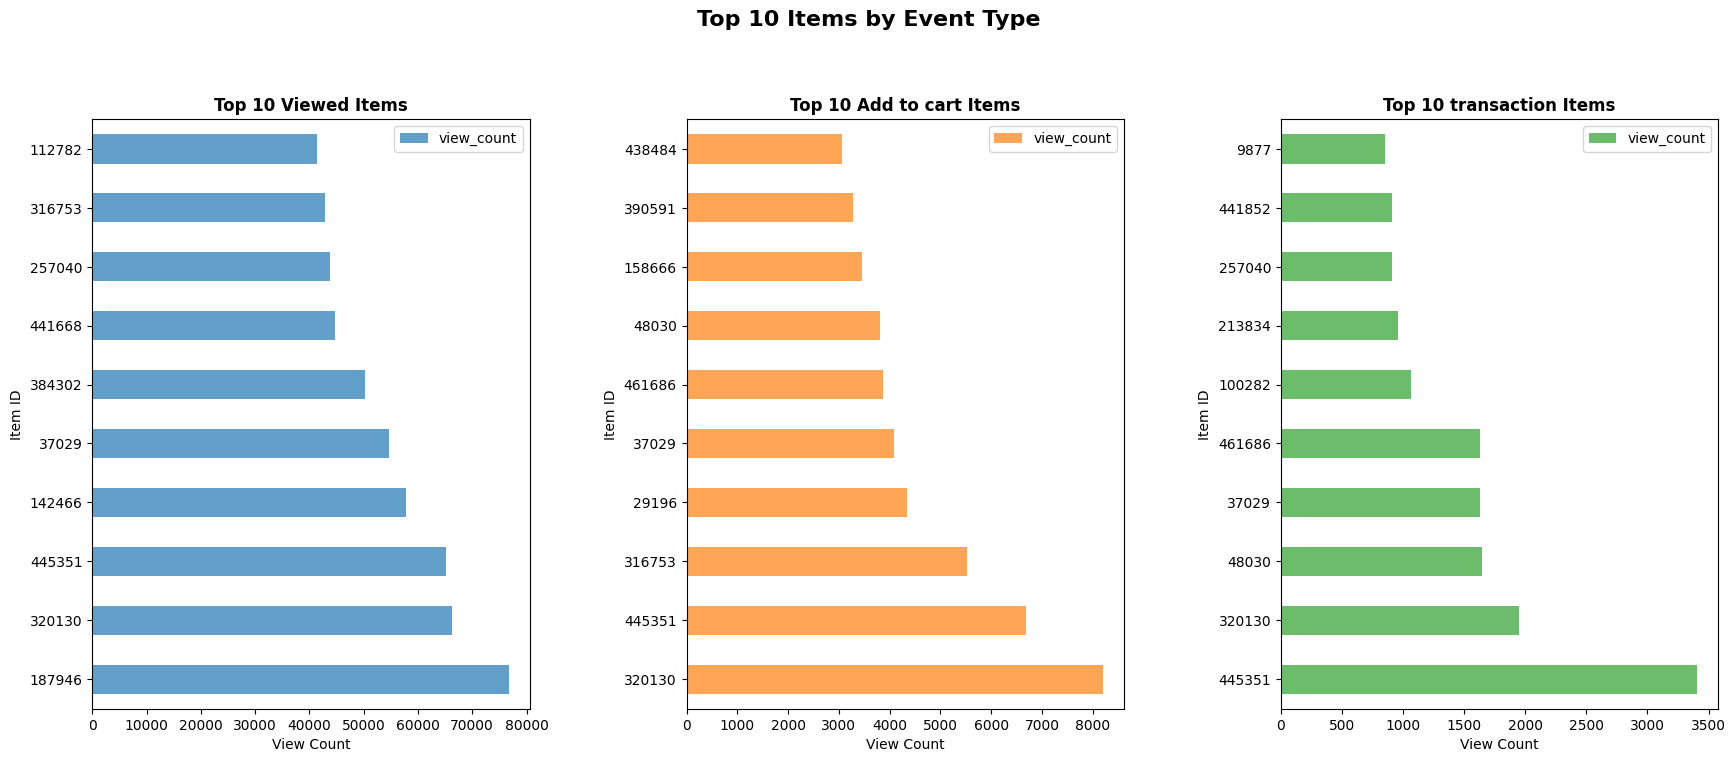

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt


top_100_addtocart.to_parquet(pth / "top_100_addtocart.parquet")

top_100_transaction.to_parquet(pth / "top_100_transaction.parquet")

top_100_view.to_parquet(pth / "top_100_view.parquet")

# Создание графиков с настройками
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
fig.suptitle("Top 10 Items by Event Type", fontsize=16, fontweight="bold")

# Цвета для разных типов событий
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # blue, orange, green


top_100_view.head(10).plot.barh(
    x="itemid", y="view_count", ax=axes[0], color=colors[0], alpha=0.7
)

axes[0].set_title("Top 10 Viewed Items", fontweight="bold")
axes[0].set_xlabel("View Count")
axes[0].set_ylabel("Item ID")

top_100_addtocart.head(10).plot.barh(
    x="itemid", y="view_count", ax=axes[1], color=colors[1], alpha=0.7
)
axes[1].set_title("Top 10 Add to cart Items", fontweight="bold")
axes[1].set_xlabel("View Count")
axes[1].set_ylabel("Item ID")

top_100_transaction.head(10).plot.barh(
    x="itemid", y="view_count", ax=axes[2], color=colors[2], alpha=0.7
)
axes[2].set_title("Top 10 transaction Items", fontweight="bold")
axes[2].set_xlabel("View Count")
axes[2].set_ylabel("Item ID")

plt.tight_layout(pad=3.0, w_pad=4.0, h_pad=3.0)

fig.savefig(pth / "Top_10_items.png")

In [27]:
del (
    fig,
    axes,
    top_100_view,
    top_100_addtocart,
    top_100_transaction,
    train_original_columns,
)

Добавляем веса в train и test по значениею event

In [28]:
event_weights = {"view": 1.0, "addtocart": 3.0, "transaction": 5.0}

categories_events = list(train_transformer.named_transformers_["cats"].categories_[1])

id_events = {item: categories_events.index(item) for item in categories_events}

In [29]:
event_weights_id = {
    id_events.get(key): [value, key] for key, value in event_weights.items()
}

event_weights_id

{2: [1.0, 'view'], 0: [3.0, 'addtocart'], 1: [5.0, 'transaction']}

In [30]:
train.columns

Index(['cats__visitorid', 'cats__event', 'cats__itemid', 'cats__available',
       'cats__categoryid', 'cats__level_0', 'cats__level_1', 'cats__level_2',
       'cats__level_3', 'cats__level_4', 'cats__level_5',
       'cats__root_category', 'numscaler__property', 'numscaler__value_count',
       'numscaler__value_first', 'numscaler__value_last',
       'numscaler__value_min', 'numscaler__value_max', 'numscaler__value_mean',
       'numscaler__value_std', 'remainder__timestamp_x',
       'remainder__timestamp_y'],
      dtype='object')

In [31]:
train["event_weight"] = train["cats__event"].apply(lambda x: event_weights_id.get(x)[0])
test["event_weight"] = test["cats__event"].apply(lambda x: event_weights_id.get(x)[0])

In [32]:
train.to_parquet(pth / "train_preprocessed_event_weight.parquet")
test.to_parquet(pth / "test_preprocessed_event_weight.parquet")

In [ ]:
user_item_ratings_train = (
    train.groupby(["cats__visitorid", "cats__itemid"])
    .agg(
        {"event_weight": "sum", "cats__event": "count", "remainder__timestamp_x": "max"}
    )
    .reset_index()
)

user_item_ratings_test = (
    test.groupby(["cats__visitorid", "cats__itemid"])
    .agg(
        {"event_weight": "sum", "cats__event": "count", "remainder__timestamp_x": "max"}
    )
    .reset_index()
)

In [34]:
del train, test

In [35]:
pth_als = Path("ALS_assets").resolve()

pth_als.mkdir(exist_ok=True, parents=True)

In [ ]:
user_item_ratings_train.columns = [
    "visitoridx",
    "itemidx",
    "rating",
    "interactions",
    "last_interaction",
]

user_item_ratings_test.columns = [
    "visitoridx",
    "itemidx",
    "rating",
    "interactions",
    "last_interaction",
]

user_item_ratings_train

,visitoridx,itemidx,rating,interactions,last_interaction
0,0.0,25819.0,9.0,9,1.439488e+12
1,1.0,77362.0,24.0,24,1.438971e+12
2,1.0,92967.0,31.0,31,1.438970e+12
3,1.0,116309.0,96.0,96,1.438972e+12
4,1.0,122675.0,14.0,14,1.438971e+12
...,...,...,...,...,...
1531341,991964.0,43564.0,5.0,5,1.433973e+12
1531342,991965.0,127505.0,25.0,25,1.433344e+12
1531343,991966.0,153091.0,5.0,5,1.431899e+12
1531344,991967.0,67558.0,6.0,6,1.431826e+12


In [ ]:
user_item_ratings_train.to_parquet(pth_als / "user_item_ratings_train.parquet")
user_item_ratings_test.to_parquet(pth_als / "user_item_ratings_test.parquet")

In [38]:
import scipy


n_users = int(user_item_ratings_train["visitoridx"].max() + 1)
n_items = int(user_item_ratings_train["itemidx"].max() + 1)

user_item_matrix_train = scipy.sparse.csr_matrix(
    (
        user_item_ratings_train["rating"],
        (user_item_ratings_train["visitoridx"], user_item_ratings_train["itemidx"]),
    ),
    shape=(n_users, n_items),
    dtype=np.float64,
)

In [39]:
from implicit.als import AlternatingLeastSquares

als_model = AlternatingLeastSquares(
    factors=50, iterations=50, regularization=0.05, random_state=42
)
als_model.fit(user_item_matrix_train)

/home/yoh/project/mle-pr-final/.venv/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 16 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/50 [00:00<?, ?it/s]

In [45]:
als_model.save(pth_als / "als_model.npz")

In [40]:
users = user_item_ratings_train["visitoridx"].unique().astype(int)

als_recommendations = als_model.recommend(
    users, user_item_matrix_train[users], filter_already_liked_items=False, N=100
)

In [41]:
als_recommendations = pd.DataFrame(
    {
        "visitoridx": users,
        "itemidx": als_recommendations[0].tolist(),
        "rating": als_recommendations[1].tolist(),
    }
)

In [42]:
als_recommendations = als_recommendations.explode(
    ["itemidx", "rating"], ignore_index=True
)

als_recommendations

,visitoridx,itemidx,rating
0,0,137553,0.006669
1,0,140671,0.00587
2,0,57964,0.005481
3,0,32716,0.005304
4,0,74013,0.005094
...,...,...,...
99196895,991968,133843,0.000019
99196896,991968,4550,0.000019
99196897,991968,105503,0.000019
99196898,991968,42655,0.000019


In [43]:
als_recommendations.to_parquet(pth_als / "als_recommendations.parquet")

In [44]:
del als_recommendations

In [1]:
import pandas as pd
import joblib


als_recommendations = pd.read_parquet("ALS_assets/als_recommendations.parquet")

user_item_ratings_train = pd.read_parquet("ALS_assets/user_item_ratings_train.parquet")

user_item_ratings_test = pd.read_parquet("ALS_assets/user_item_ratings_test.parquet")

test_transformer = joblib.load("features_assets/test_transformer.pkl")

train_transformer = joblib.load("features_assets/train_transformer.pkl")

In [2]:
user_item_ratings_test

,visitoridx,itemidx,rating,interactions,last_interaction
0,0.0,10709.0,38.0,38,1.442005e+12
1,0.0,45536.0,34.0,34,1.442005e+12
2,0.0,57026.0,7.0,7,1.442005e+12
3,1.0,10409.0,57.0,19,1.440915e+12
4,1.0,40363.0,17.0,17,1.440917e+12
...,...,...,...,...,...
254940,178743.0,23520.0,10.0,10,1.441140e+12
254941,178744.0,71185.0,7.0,7,1.442116e+12
254942,178745.0,8517.0,31.0,31,1.441111e+12
254943,178746.0,38470.0,33.0,33,1.440901e+12


In [3]:
from sklearn.compose import ColumnTransformer


def create_id_mapping(
    transformer: ColumnTransformer, user_item_ratings: pd.DataFrame
) -> tuple[dict, dict]:
    # Извлекаем оригинальные id из трансформера для категориальных признаков
    visitorid_transformer_id = list(
        transformer.named_transformers_["cats"].categories_[0]
    )
    itemid_transformer_id = list(transformer.named_transformers_["cats"].categories_[2])

    # Получаем уникальные индексы из тестового набора
    visitoridx = user_item_ratings["visitoridx"].unique().tolist()
    itemidx = user_item_ratings["itemidx"].unique().tolist()

    # Сортируем индексы для корректного сопоставления
    visitoridx.sort()
    itemidx.sort()

    # Создаем словари {внутренний_индекс: оригинальный_id}
    cross_visitoridx = {}
    cross_itemidx = {}

    for internal_idx, original_id in zip(visitoridx, visitorid_transformer_id):
        cross_visitoridx[internal_idx] = original_id

    for internal_idx, original_id in zip(itemidx, itemid_transformer_id):
        cross_itemidx[internal_idx] = original_id

    return cross_visitoridx, cross_itemidx

In [4]:
cross_visitoridx_test, cross_itemidx_test = create_id_mapping(
    test_transformer, user_item_ratings_test
)

cross_visitoridx_train, cross_itemidx_train = create_id_mapping(
    train_transformer, user_item_ratings_train
)

In [5]:
user_item_ratings_test["visitorid"] = user_item_ratings_test["visitoridx"].apply(
    lambda x: cross_visitoridx_test.get(x)
)
user_item_ratings_test["itemid"] = user_item_ratings_test["itemidx"].apply(
    lambda x: cross_itemidx_test.get(x)
)

als_recommendations["visitorid"] = als_recommendations["visitoridx"].apply(
    lambda x: cross_visitoridx_train.get(x)
)
als_recommendations["itemid"] = als_recommendations["itemidx"].apply(
    lambda x: cross_itemidx_train.get(x)
)

In [6]:
als_recommendations

,visitoridx,itemidx,rating,visitorid,itemid
0,0,137553,0.006669,1,384302
1,0,140671,0.005870,1,393028
2,0,57964,0.005481,1,161623
3,0,32716,0.005304,1,91105
4,0,74013,0.005094,1,206880
...,...,...,...,...,...
99196895,991968,133843,0.000019,1407579,374006
99196896,991968,4550,0.000019,1407579,13026
99196897,991968,105503,0.000019,1407579,294807
99196898,991968,42655,0.000019,1407579,118752


In [7]:
user_item_ratings_test

,visitoridx,itemidx,rating,interactions,last_interaction,visitorid,itemid
0,0.0,10709.0,38.0,38,1.442005e+12,0,67045
1,0.0,45536.0,34.0,34,1.442005e+12,0,285930
2,0.0,57026.0,7.0,7,1.442005e+12,0,357564
3,1.0,10409.0,57.0,19,1.440915e+12,6,65273
4,1.0,40363.0,17.0,17,1.440917e+12,6,253615
...,...,...,...,...,...,...,...
254940,178743.0,23520.0,10.0,10,1.441140e+12,1407540,147509
254941,178744.0,71185.0,7.0,7,1.442116e+12,1407549,446411
254942,178745.0,8517.0,31.0,31,1.441111e+12,1407553,53332
254943,178746.0,38470.0,33.0,33,1.440901e+12,1407559,241612


Объединим user_item_ratings_train и als_recommendations

In [26]:
a2 = als_recommendations.merge(
    user_item_ratings_test[["visitorid", "itemid", "interactions", "rating"]].rename(
        columns={"rating": "score"}
    ),
    on=["visitorid", "itemid"],
    how="left",
)

In [28]:
a2.head()

,visitoridx,itemidx,rating,visitorid,itemid,interactions,score
0,0,137553,0.006669,1,384302,NaN,NaN
1,0,140671,0.005870,1,393028,NaN,NaN
2,0,57964,0.005481,1,161623,NaN,NaN
3,0,32716,0.005304,1,91105,NaN,NaN
4,0,74013,0.005094,1,206880,NaN,NaN


In [50]:
import sklearn.metrics
import numpy as np


def compute_ndcg(rating: pd.Series, score: pd.Series, k):
    """подсчёт ndcg
    rating: истинные оценки
    score: оценки модели
    k: количество айтемов (по убыванию score) для оценки, остальные - отбрасываются
    """

    # если кол-во объектов меньше 2, то NDCG - не определена
    if len(rating) < 2:
        return np.nan

    ndcg = sklearn.metrics.ndcg_score(
        np.asarray([rating.to_numpy()]), np.asarray([score.to_numpy()]), k=k
    )

    return ndcg


mask = ~a2["score"].isnull()

ndcg_at_5_scores = (
    a2[mask]
    .groupby("visitoridx")
    .apply(lambda x: compute_ndcg(x["rating"], x["score"], k=5))
)

ndcg_at_2_scores = (
    a2[mask]
    .groupby("visitoridx")
    .apply(lambda x: compute_ndcg(x["rating"], x["score"], k=2))
)

NameError: name 'a2' is not defined

In [42]:
ndcg_at_5_scores_res = {
    "ndcg_5_mean": ndcg_at_5_scores.mean(),
    "ndcg_5_mode": ndcg_at_5_scores.mode().iloc[0],
    "ndcg_5_std": ndcg_at_5_scores.std(),
    "ndcg_5_std_Nan_rel": (ndcg_at_5_scores.isnull().sum() / len(ndcg_at_5_scores)),
}

ndcg_at_2_scores_res = {
    "ndcg_2_mean": ndcg_at_2_scores.mean(),
    "ndcg_2_mode": ndcg_at_2_scores.mode().iloc[0],
    "ndcg_2_std": ndcg_at_2_scores.std(),
    "ndcg_2_std_Nan_rel": (ndcg_at_2_scores.isnull().sum() / len(ndcg_at_2_scores)),
}

In [ ]:
del ndcg_at_5_scores, ndcg_at_2_scores, mask, a2

In [57]:
ndcg_at_5_scores_res = {key: float(item) for key, item in ndcg_at_5_scores_res.items()}

ndcg_at_2_scores_res = {key: float(item) for key, item in ndcg_at_2_scores_res.items()}

In [58]:
import json

with open("ALS_assets/ndcg_at_5_scores_res.json", "w") as f:
    json.dump(ndcg_at_5_scores_res, f)

with open("ALS_assets/ndcg_at_2_scores_res.json", "w") as f:
    json.dump(ndcg_at_2_scores_res, f)

In [24]:
import mlflow
from utils_mlflow import setup_mlflow_client, setup_env


setup_env()

client = setup_mlflow_client()

EXPERIMENT_NAME = "online_recommendations_pr_final"
RUN_NAME = "features_als"


if client.get_experiment_by_name(EXPERIMENT_NAME) is None:
    experiment_id = client.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = client.get_experiment_by_name(EXPERIMENT_NAME).experiment_id


mlflow.set_tracking_uri(client.tracking_uri)
mlflow.set_registry_uri(client.tracking_uri)

In [25]:
with mlflow.start_run(experiment_id=experiment_id, run_name=RUN_NAME) as run:
    mlflow.log_artifacts(local_dir="features_assets", artifact_path="features_assets")

🏃 View run features_als at: http://127.0.0.1:5000/#/experiments/17/runs/81e0c9b7f7bd4fb8ada2f3bf8c40bc4e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/17


Найдем на каждый товар 10 похожих 

In [1]:
from implicit.als import AlternatingLeastSquares
import joblib
import pandas as pd

In [2]:
from create_id_mapping import create_id_mapping

In [6]:
als_model = AlternatingLeastSquares().load("ALS_assets/als_model.npz")

train_transformers = joblib.load("features_assets/train_transformer.pkl")

item_properties_train = pd.read_parquet(
    "features_assets/train_preprocessed_event_weight.parquet"
)

cross_visitoridx, cross_itemidx = create_id_mapping(
    train_transformers,
    item_properties_train,
    visitoridx_name="cats__visitorid",
    itemidx_name="cats__itemid",
)

In [7]:
del item_properties_train, train_transformers

In [10]:
max_similar_items = 10

indexes = list(map(int, cross_itemidx.keys()))

similar_items = als_model.similar_items(indexes, N=max_similar_items + 1)

In [14]:
item_items_idx, item_items_scores = similar_items

In [ ]:
similar_items_df = pd.DataFrame(
    {
        "items_idx": item_items_idx.tolist(),
        "sim_item_id_idx": item_items_idx.tolist(),
        "score": item_items_scores.tolist(),
    }
)
similar_items_df = similar_items_df.explode(["sim_item_id_idx", "score"]).reset_index(
    drop=True
)

similar_items_df.drop(
    index=similar_items_df.loc[
        similar_items_df["items_idx"] == similar_items_df["sim_item_id_idx"]
    ].index,
    inplace=True,
)
similar_items_df["items_idx_t"] = similar_items_df["items_idx"].apply(lambda x: x[0])

similar_items_df.drop(columns=["items_idx"], inplace=True)
similar_items_df.drop(
    similar_items_df.query("items_idx_t == sim_item_id_idx").index, inplace=True
)

similar_items_df.rename(columns={"items_idx_t": "items_idx"}, inplace=True)

In [41]:
cross_itemidx = {key: float(item) for key, item in cross_itemidx.items()}

cross_visitoridx = {key: float(item) for key, item in cross_visitoridx.items()}

In [44]:
import json

similar_items_df.to_parquet("ALS_assets/similar_items_df.parquet")

with open("ALS_assets/hash_itemidx_train.json", "w") as f:
    json.dump(cross_itemidx, f)

with open("ALS_assets/hash_visitoridx_train.json", "w") as f:
    json.dump(cross_visitoridx, f)

In [45]:
import mlflow
from utils_mlflow import setup_mlflow_client, setup_env


setup_env()

client = setup_mlflow_client()

EXPERIMENT_NAME = "online_recommendations_pr_final"
RUN_NAME = "ALS_and_similar_items"


if client.get_experiment_by_name(EXPERIMENT_NAME) is None:
    experiment_id = client.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = client.get_experiment_by_name(EXPERIMENT_NAME).experiment_id


mlflow.set_tracking_uri(client.tracking_uri)
mlflow.set_registry_uri(client.tracking_uri)

In [46]:
with mlflow.start_run(experiment_id=experiment_id, run_name=RUN_NAME) as run:
    mlflow.log_artifacts(local_dir="ALS_assets", artifact_path="ALS_assets")

🏃 View run ALS_and_similar_items at: http://127.0.0.1:5000/#/experiments/17/runs/38eb51d21cdf497abdee5ce0073c6b5b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/17
